In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
import supy as sp
import os

In [36]:
name='US-KUT'
year=2006
df=pd.read_csv('data_csv_zip_clean/'+name+'_clean.csv.gz')
df.time=pd.to_datetime(df.time)
df=df.set_index(['time'])
df.head()

,WS,RH,TA,PA,WD,P,SWIN,LWIN,SWOUT,LWOUT,NETRAD,H,LE
time,,,,,,,,,,,,,
2005-11-27 00:30:00,NaN,NaN,-3.615,NaN,NaN,0.0,-1.44,NaN,NaN,NaN,NaN,NaN,NaN
2005-11-27 01:00:00,NaN,NaN,-3.307,NaN,NaN,0.0,-1.44,NaN,NaN,NaN,NaN,NaN,NaN
2005-11-27 01:30:00,NaN,NaN,-3.000,NaN,NaN,0.0,-1.44,NaN,NaN,NaN,NaN,NaN,NaN
2005-11-27 02:00:00,NaN,NaN,-2.545,NaN,NaN,0.0,-1.44,NaN,NaN,NaN,NaN,NaN,NaN
2005-11-27 02:30:00,NaN,NaN,-2.090,NaN,NaN,0.0,-1.44,NaN,NaN,NaN,NaN,NaN,NaN


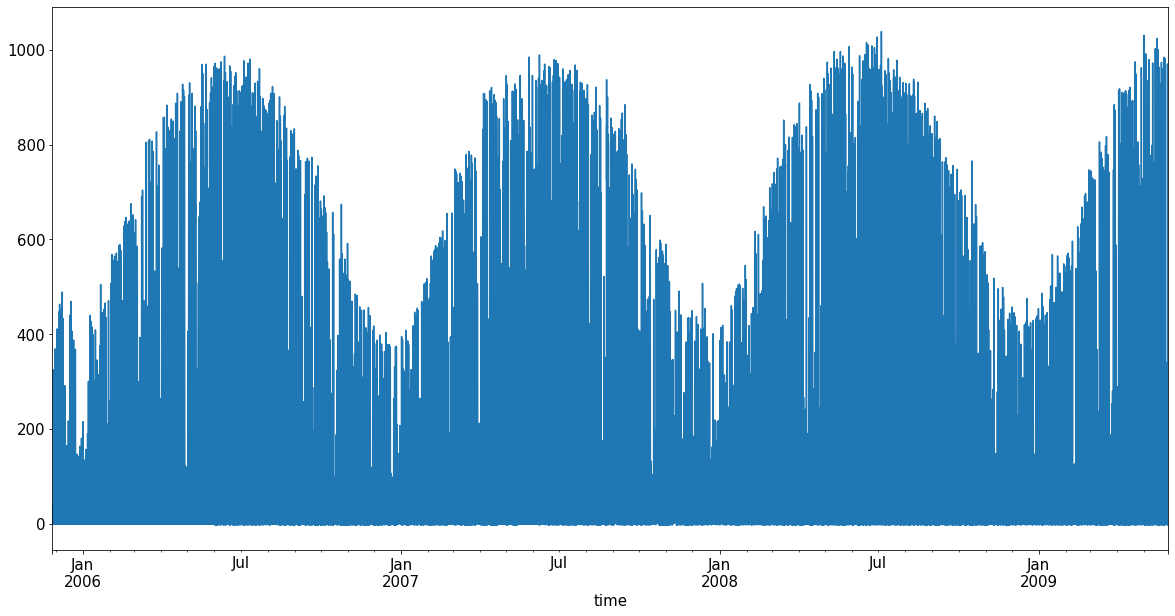

In [37]:
fig,ax=plt.subplots(1,1)
plt.rcParams.update({'font.size': 15})
df.SWIN.plot(figsize=(20,10),ax=ax)

In [38]:
temp=df[df.LE<0]
df.loc[temp.index,'LE']=np.nan
df=df.resample('1h').mean()

period_start=str(year)+'-01-01'
period_end=str(year+1)+'-01-01'
df_period=df[(df.index>=period_start) & (df.index<period_end)]

/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


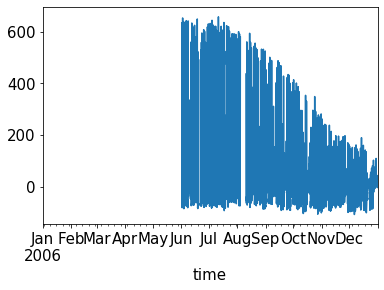

In [39]:
df_period['NETRAD']=(df_period['SWIN']-df_period['SWOUT'])+(df_period['LWIN']-df_period['LWOUT'])
df_period['NETRAD'].plot()

In [40]:
qs = df_period.apply (lambda row: row['NETRAD']-row['LE']-row['H'], axis=1)
df_period = df_period.assign(QS=qs.values)

Text(0, 0.5, 'W m$^{-2}$')

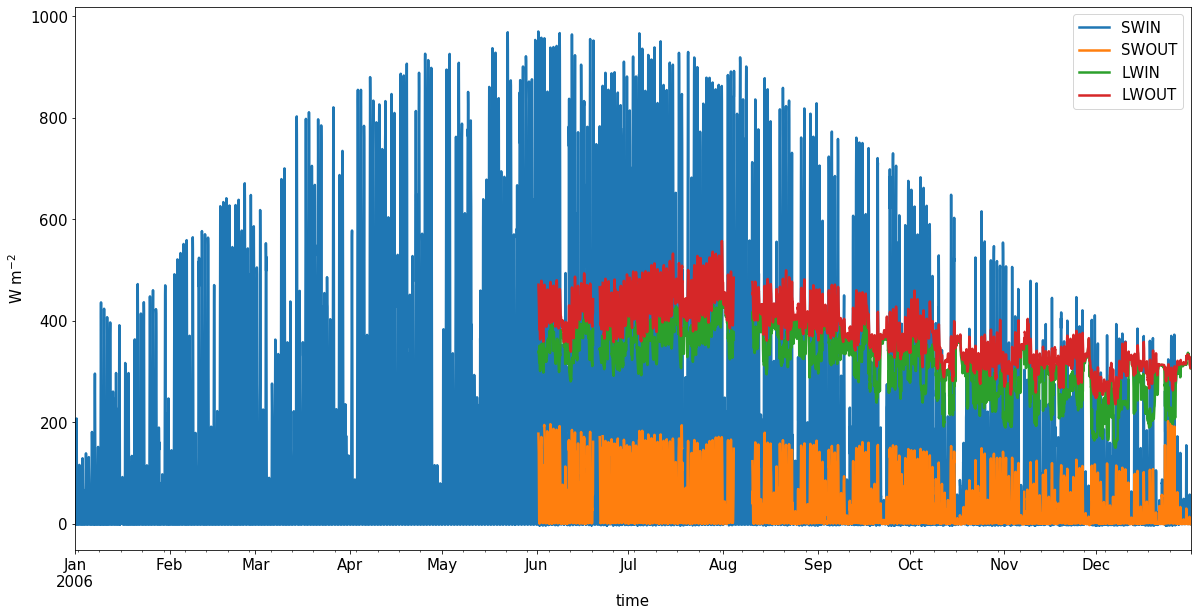

In [41]:
fig,ax=plt.subplots(1,1)
plt.rcParams.update({'font.size': 15})
df_period[['SWIN','SWOUT','LWIN','LWOUT']].plot(linewidth=2.5,figsize=(20,10),ax=ax)
ax.set_ylabel('W m$^{-2}$')

In [42]:
input_columns=['iy', 'id', 'it', 'imin', 'qn', 'qh', 'qe', 'qs', 'qf', 'U', 'RH', 'Tair', 'pres', 'rain', 
'kdown', 'snow', 'ldown', 'fcld', 'wuh', 'xsmd', 'lai', 'kdiff', 'kdir', 'wdir']
df_input=pd.DataFrame(columns=input_columns)
df_input.iy=df_period.index.year
df_input.id=[x.timetuple().tm_yday for x in df_period.index]
df_input.it=df_period.index.hour
df_input.imin=df_period.index.minute
df_input['kdown']=df_period.SWIN.values
df_input['ldown']=df_period.LWIN.values
df_input['U']=df_period.WS.values
df_input['snow']=0
df_input['rain']=0
df_input['rain']=df_period.P.values
df_input['RH']=df_period.RH.values
df_input['Tair']=df_period.TA.values
df_input['pres']=df_period.PA.values
df_input['qf']=0

In [43]:
for i in ['rain','U','RH','pres']:
    df_input.loc[df_input[df_input[i]<0].index,i]=-999
    
df_input.loc[df_input[df_input['Tair']<-50].index,'Tair']=-999
df_input.fillna(-999,inplace=True)
df_input.replace(-999,np.nan,inplace=True)
df_input.interpolate(limit_direction='both',inplace=True)
df_input.fillna(-999,inplace=True)

In [44]:
df_input.to_csv('Kc_2012_data_60.txt',sep=' ',index=0)
os.rename("./Kc_2012_data_60.txt", "runs/run/input/Kc_2012_data_60.txt")

In [45]:
all_sites_info =  pd.read_csv('site_info.csv')
site_info=all_sites_info[all_sites_info['Site Id'] == name]
df = pd.DataFrame(
    {'Site': [name],
     'Latitude': [site_info['Latitude (degrees)']],
     'Longitude': [site_info['Longitude (degrees)']]})


In [46]:
path_runcontrol = Path('./runs/run/') / 'RunControl.nml'
df_state_init = sp.init_supy(path_runcontrol)
grid = df_state_init.index[0]
df_forcing = sp.load_forcing_grid(path_runcontrol, grid)

In [47]:
def modify_attr(df_state_init):
    df_state_init.loc[:,'emissionsmethod']=0
    df_state_init.loc[:,'sfr']=[0.0, #Paved
                            0.0, #Bldg
                            0.0, #EveTr
                            0.0, #DecTr
                            1.0, #Grass
                            0.0, #Bsoil
                            0.0] #Water
    df_state_init.loc[:,'lat']=df.Latitude.values[0].values[0]
    df_state_init.loc[:,'lng']=df.Longitude.values[0].values[0]
    return df_state_init
df_state_init=modify_attr(df_state_init)

In [48]:
df_state_init[['sfr','lat','lng']]

var      sfr                                  lat    lng
ind_dim (0,) (1,) (2,) (3,) (4,) (5,) (6,)      0      0
grid                                                    
98       0.0  0.0  0.0  0.0  1.0  0.0  0.0  44.99 -93.19

In [49]:
error=10
for i in range(10):
    
    if (error <= 0.1):
        break
    df_output, df_state_final = sp.run_supy(df_forcing, df_state_init,save_state=False)
    final_state = df_state_final[df_state_init.columns.levels[0]].iloc[1]
    df_state_init.iloc[0] = final_state
    soilstore_before = df_state_final.soilstore_id.iloc[0]
    soilstore_after = df_state_final.soilstore_id.iloc[1]
    diff_soil = sum(abs(soilstore_after-soilstore_before))
    error = 100*diff_soil/soilstore_before.mean()
    print(error)


289.0189916467549
45.598001305672334
40.86864886538404
22.490536840836178
17.05918099856473
7.865102923522425
7.777713607656761
7.692244926300672
7.608634241739634
7.526821635702067


In [50]:
df_output_2=df_output.SUEWS.loc[grid].resample('1h').mean()
df_input.qe=df_period.LE.values
df_input.qh=df_period.H.values
df_input.qn=df_period.NETRAD.values
df_input.xsmd=df_output_2.iloc[1:,:].SMD.values
df_input.lai=df_output_2.iloc[1:,:].LAI.values
df_input.wdir=df_period.WD.values
df_input.fillna(-999,inplace=True)
df_input.to_csv('runs/data/'+name+'_'+str(int(df_input.iloc[0].iy))+'_data_60.txt',sep=' ',index=0)